###  Introduction
This code and the explenation behind can be found at the following youtube link.
https://www.youtube.com/watch?v=lUI6VMj43PE

All I've done is reupload it to github as the link in the video description is no longer available.

### Dataset
http://www.cis.fordham.edu/wisdm/dataset.php 

### Tree structure
```
/
├── data/
│   ├── readme.txt
│   ├── WISDM_ar_v1.1_raw.txt
│   ├── WISDM_ar_v1.1_raw_about.txt
│   ├── WISDM_ar_v1.1_trans_about.txt
│   └── WISDM_ar_v1.1_transformed.arff
└── HAR classifier with TensorFlow 2.0.ipynb
```

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.1.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [3]:
processed_list = []

with open('data/WISDM_ar_v1.1_raw.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        try:
            line = line.split(",")
            last = line[5].split(";")[0]
            last = last.strip()
            if last == '':
                break
            temp = line[:5] + [last]
            processed_list.append(temp)
        except Exception as e:
            print(e)
            print("error at line number:", i, line)

list index out of range
error at line number: 281873 ['\n']
list index out of range
error at line number: 281874 ['\n']
list index out of range
error at line number: 281875 ['\n']


In [4]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [5]:
data = pd.DataFrame(data=processed_list, columns=columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [6]:
data.shape

(343416, 6)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


In [8]:
data.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [9]:
data['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [10]:
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


In [12]:
fs = 20
activities = data['activity'].value_counts().index

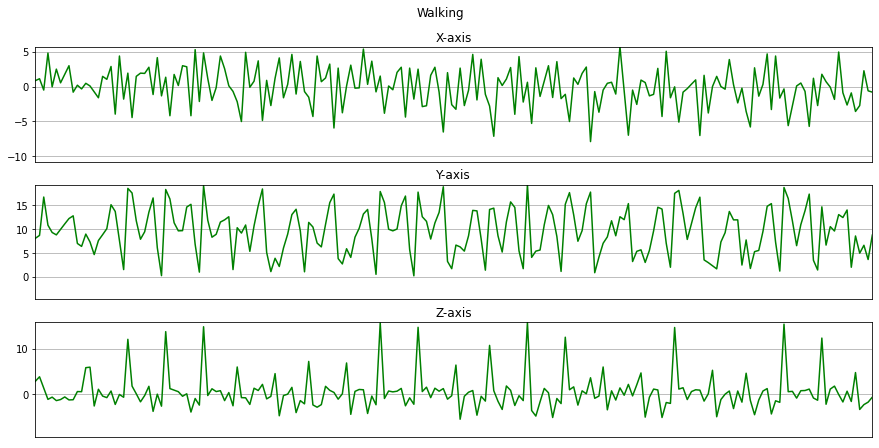

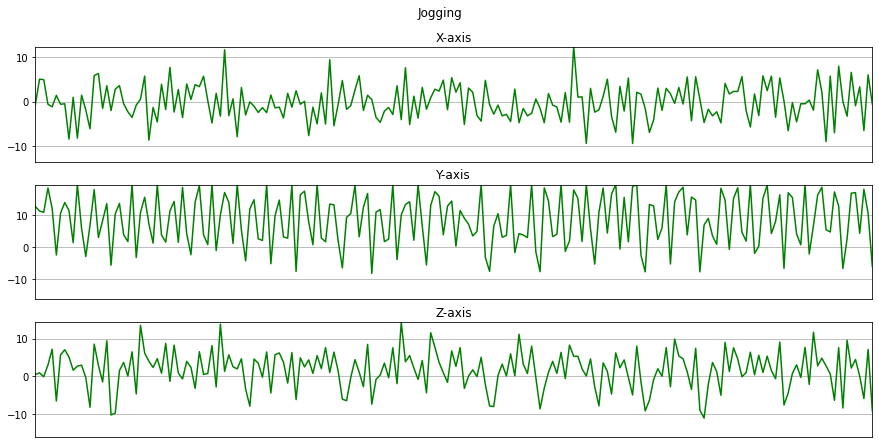

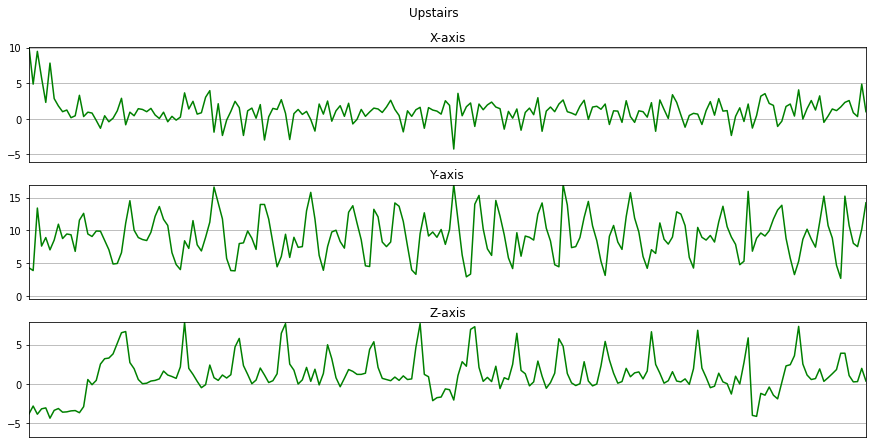

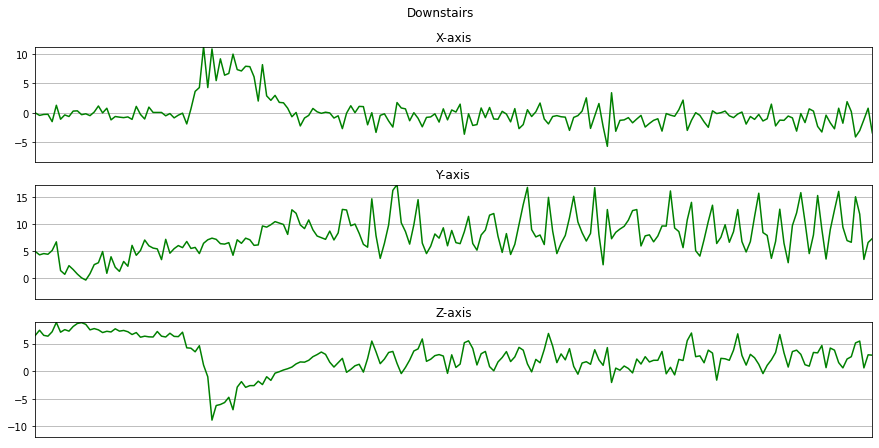

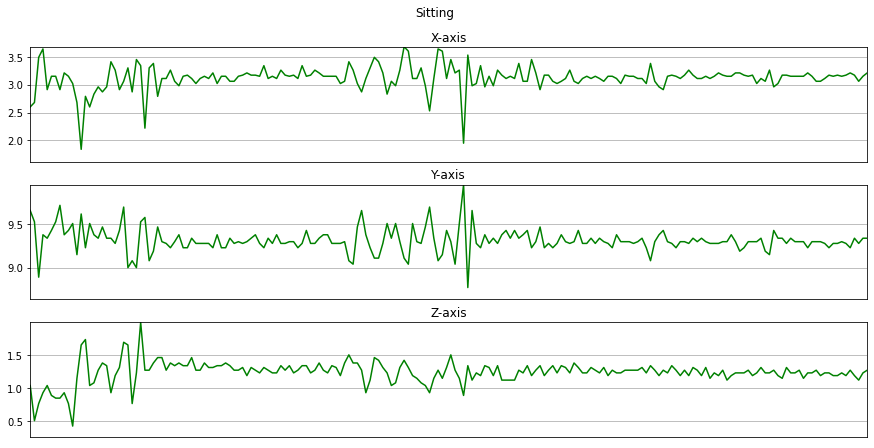

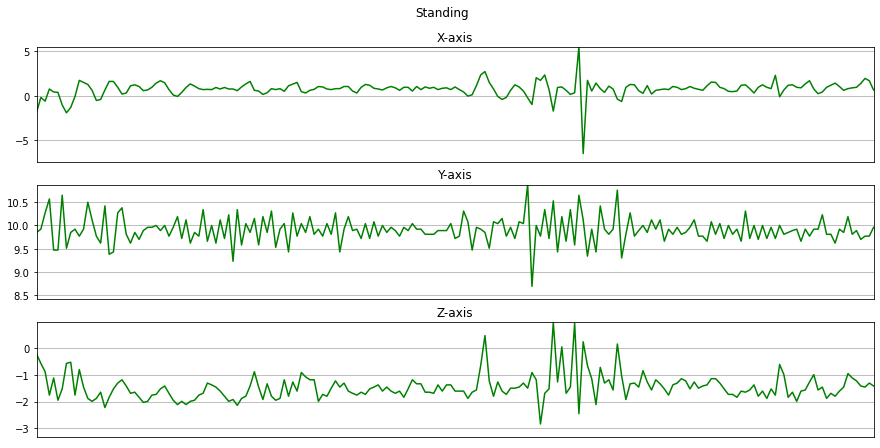

In [13]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-axis')
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim(min(y) - np.std(y), max(y), + np.std(y))
    ax.set_xlim(min(x), max(x))
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:fs * 10]
    plot_activity(activity, data_for_plot)

In [14]:
df = data.drop(['user', 'time'], axis=1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [15]:
min_activity = df['activity'].value_counts().min()
df['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [16]:
walking = df[df['activity'] == 'Walking'].head(min_activity).copy()
jogging = df[df['activity'] == 'Jogging'].head(min_activity).copy()
upstairs = df[df['activity'] == 'Upstairs'].head(min_activity).copy()
downstairs = df[df['activity'] == 'Downstairs'].head(min_activity).copy()
sitting = df[df['activity'] == 'Sitting'].head(min_activity).copy()
standing = df[df['activity'] == 'Standing'].head(min_activity).copy()

In [17]:
balanced_df = pd.DataFrame()
balanced_df = balanced_df.append([walking, jogging, upstairs, downstairs, sitting, standing])
balanced_df.shape

(21330, 4)

In [18]:
balanced_df['activity'].value_counts()

Standing      3555
Jogging       3555
Sitting       3555
Upstairs      3555
Downstairs    3555
Walking       3555
Name: activity, dtype: int64

In [19]:
balanced_df.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


In [20]:
label = LabelEncoder()
balanced_df['label'] = label.fit_transform(balanced_df['activity'])


In [21]:
print(label.classes_)
balanced_df.head()

['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


### Standardized data

In [22]:
x = balanced_df[['x', 'y', 'z']]
y = balanced_df['label']

In [23]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

scaled_x = pd.DataFrame(data=x, columns=['x', 'y', 'z'])
scaled_x['label'] = y.values

scaled_x

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


### Frame preparation

In [24]:
import scipy.stats as stats

In [25]:
frame_size = fs * 4 # one frame is constituted of 4 seconds of datah
hop_size = fs * 2

In [26]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    frames = []
    labels = []
    
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i:i+frame_size]
        y = df['y'].values[i:i+frame_size]
        z = df['z'].values[i:i+frame_size]
        
        # retrieve the most often used label in this segment
        label = stats.mode(df['label'][i:i+frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)
    
    # bring the segment into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels


In [27]:
x, y = get_frames(scaled_x, frame_size, hop_size)

In [28]:
x.shape, y.shape

((532, 80, 3), (532,))

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [30]:
x_train.shape, x_test.shape 

((425, 80, 3), (107, 80, 3))

In [31]:
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)


In [32]:
x_train[0].shape, x_test[0].shape 

((80, 3, 1), (80, 3, 1))

### 2D CNN Model

In [33]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation='relu', input_shape=x_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [34]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=1)

Train on 425 samples, validate on 107 samples
Epoch 1/10
425/425 [==============================] - 0s 812us/sample - loss: 1.6733 - accuracy: 0.2000 - val_loss: 1.4258 - val_accuracy: 0.3832
Epoch 2/10
425/425 [==============================] - 0s 198us/sample - loss: 1.3383 - accuracy: 0.4612 - val_loss: 1.1003 - val_accuracy: 0.7664
Epoch 3/10
425/425 [==============================] - 0s 176us/sample - loss: 1.0803 - accuracy: 0.5953 - val_loss: 0.7904 - val_accuracy: 0.8598
Epoch 4/10
425/425 [==============================] - 0s 165us/sample - loss: 0.7919 - accuracy: 0.7318 - val_loss: 0.5458 - val_accuracy: 0.8692
Epoch 5/10
425/425 [==============================] - 0s 164us/sample - loss: 0.5684 - accuracy: 0.8024 - val_loss: 0.3716 - val_accuracy: 0.8879
Epoch 6/10
425/425 [==============================] - 0s 161us/sample - loss: 0.4384 - accuracy: 0.8588 - val_loss: 0.3508 - val_accuracy: 0.8598
Epoch 7/10
425/425 [==============================] - 0s 160us/sample - loss: 

In [36]:
def plot_learning_curve(history, epochs):
    # Plot training and valiation accuracy values    
    epoch_range = range(1, epochs + 1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title("Model accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    # Plot training and validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title("Model loss")
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

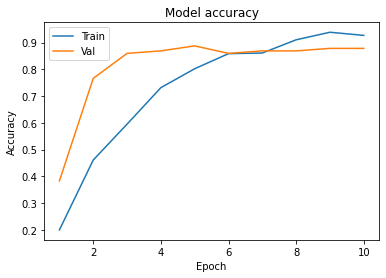

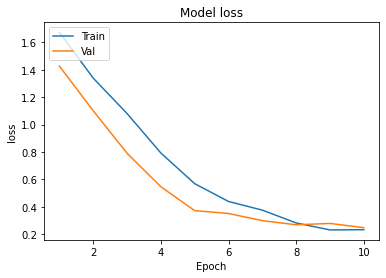

In [37]:
plot_learning_curve(history, 10)

### Confusion Matrix

In [38]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [39]:
y_pred = model.predict_classes(x_test)

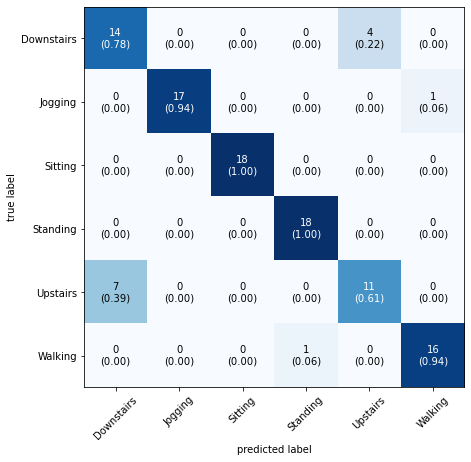

In [40]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7));

In [41]:
model.save_weights("model.h5")